In [1]:
import re # regex
import pandas as pd # tables
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import numpy as np # operations with arrays and matrices 

Load & explore data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving validation.txt to validation.txt


In [4]:
train = pd.read_csv('train.txt', header=None, sep=';', names=['Lines','Emotions'], encoding='utf-8')
test = pd.read_csv('test.txt', header=None, sep =';', names=['Lines','Emotions'], encoding='utf-8')
validation = pd.read_csv('validation.txt', header=None, sep=';', names=['Lines','Emotions'], encoding='utf-8')

In [5]:
# adding a column with encoded emotions
emotions_to_labels = {'anger': 0, 'love': 1, 'fear': 2, 'joy': 3, 'sadness': 4,'surprise': 5}
labels_to_emotions = {j:i for i,j in emotions_to_labels.items()}

train['Labels'] = train['Emotions'].replace(emotions_to_labels)
test['Labels'] = test['Emotions'].replace(emotions_to_labels)
validation['Labels'] = validation['Emotions'].replace(emotions_to_labels)

In [6]:
train.head()

,Lines,Emotions,Labels
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,1
4,i am feeling grouchy,anger,0


Exploratory Data Analysis

In [7]:
def visualize_labels_distribution(df, title='the'):
  '''
  Accepts a dataframe with 'Emotions' column and dataset title (e.g. 'train')
  Creates bar chart with num of elements of each category
  Returns nothing

  '''
  # create a pandas series with labels and their counts
  num_labels = df['Emotions'].value_counts()

  # num of unique categories
  x_barchart = range(df['Emotions'].nunique())
  # list of labels
  x_barchart_labels = [str(emotions_to_labels[emotion]) +\
                       ' - ' + emotion for emotion in list(num_labels.index)]

  # list of counts
  y_barchart = list(num_labels.values)

  # creating bar chart
  plt.figure(figsize = (6, 5))
  plt.bar(x_barchart, y_barchart, color='#707bfb')

  # adding num of elements for each category on plot as text
  for index, data in enumerate(y_barchart):
    plt.text(x = index, 
            y = data+max(y_barchart)/100, 
            s = '{}'.format(data), 
            fontdict = dict(fontsize=10), 
            ha = 'center',)
  
  plt.xticks(x_barchart, x_barchart_labels, rotation=40)
  plt.title('Num of elements of each category for {} dataset'.format(title))
  plt.tight_layout()

  print('There are {} records in the dataset.\n'.format(len(df.index)))

  plt.show()

There are 16000 records in the dataset.



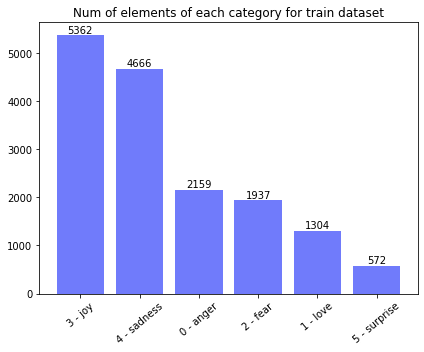

There are 2000 records in the dataset.



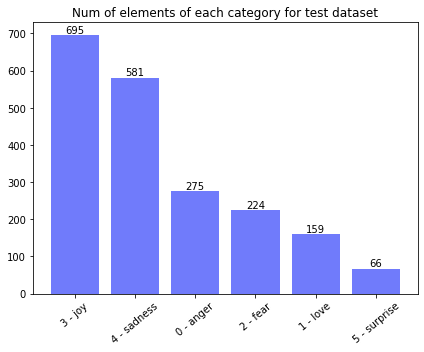

There are 2000 records in the dataset.



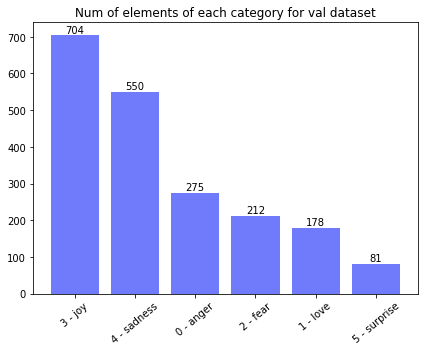

In [8]:
visualize_labels_distribution(train, 'train')
visualize_labels_distribution(test, 'test')
visualize_labels_distribution(validation, 'val')

Text Preprocessing

In [9]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# downloading a set of stop-words
STOPWORDS = set(stopwords.words('english'))

# tokenizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def text_preprocess(text, stop_words=False):
  '''
  Accepts text (a single string) and
  a parameters of preprocessing
  Returns preprocessed text

  '''
  # clean text from non-words
  text = re.sub(r'\W+', ' ', text).lower()

  # tokenize the text
  tokens = word_tokenize(text)

  if stop_words:
    # delete stop_words
    tokens = [token for token in tokens if token not in STOPWORDS]

  return tokens

In [11]:
print('Before: ')
print(train.head())

x_train = [text_preprocess(t, stop_words=True) for t in train['Lines']]
y_train = train['Labels'].values

print('\nAfter:')
for line_and_label in list(zip(x_train[:5], y_train[:5])):
  print(line_and_label)

Before: 
                                               Lines Emotions  Labels
0                            i didnt feel humiliated  sadness       4
1  i can go from feeling so hopeless to so damned...  sadness       4
2   im grabbing a minute to post i feel greedy wrong    anger       0
3  i am ever feeling nostalgic about the fireplac...     love       1
4                               i am feeling grouchy    anger       0

After:
(['didnt', 'feel', 'humiliated'], 4)
(['go', 'feeling', 'hopeless', 'damned', 'hopeful', 'around', 'someone', 'cares', 'awake'], 4)
(['im', 'grabbing', 'minute', 'post', 'feel', 'greedy', 'wrong'], 0)
(['ever', 'feeling', 'nostalgic', 'fireplace', 'know', 'still', 'property'], 1)
(['feeling', 'grouchy'], 0)


In [12]:
#test data
x_test = [text_preprocess(t, stop_words=True) for t in test['Lines']]
y_test = test['Labels'].values

#validation data
x_validation = [text_preprocess(t, stop_words=True) for t in validation['Lines']]
y_validation = validation['Labels'].values

Word embeddings

In [14]:
# load pre-trained model
import gensim.downloader as api
model_wiki = api.load('fasttext-wiki-news-subwords-300')

In [15]:
from gensim.models import Word2Vec

# train word2vec model on the corpus
model_w2v = Word2Vec(x_train + x_test + x_validation,   # data for model to train on
                     size = 300,                            # embedding vector size
                     min_count = 2).wv  

Converting sentences into vectors

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
DICT_SIZE = 15000

# creating a dictionary with most used words
# where num of words = DICT_SIZE
tokenizer = Tokenizer(num_words=DICT_SIZE)
total = x_train + x_test + x_validation
tokenizer.fit_on_texts(total)

In [18]:
# words and their indexes
list(tokenizer.word_index.items())[:5]

[('feel', 1), ('feeling', 2), ('like', 3), ('im', 4), ('really', 5)]

In [19]:
# number of unique words in the corpus
len(tokenizer.word_index)

16945

In [20]:
# find max length of sentences across all parts of the dataset
x_train_max_len = max([len(i) for i in x_train])
x_test_max_len = max([len(i) for i in x_test])
x_validation_max_len = max([len(i) for i in x_validation])

MAX_LEN = max(x_train_max_len, x_test_max_len, x_validation_max_len)

In [21]:
# max length across all sentences
MAX_LEN

35

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# replace words with their indexes, 
# change size of vectors to MAX_LEN and pad indexes 
X_train = tokenizer.texts_to_sequences(x_train)
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN)

X_test = tokenizer.texts_to_sequences(x_test)
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN)

X_val = tokenizer.texts_to_sequences(x_validation)
X_val_pad = pad_sequences(X_val, maxlen=MAX_LEN)

In [25]:
# words are replaced by their indexes
X_train[0]

[50, 1, 510]

In [26]:
# sentence after padding
X_train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  50,   1, 510], dtype=int32)

Embedding matrix

In [27]:
from gensim.models import KeyedVectors
Word2VecKeyedVectors = KeyedVectors

In [28]:
def create_weight_matrix(model, second_model=False):
  vector_size = model.get_vector('like').shape[0]
  w_matrix = np.zeros((DICT_SIZE, vector_size))
  skipped_words = []

  for word, index in tokenizer.word_index.items():
    if index < DICT_SIZE:
      if word in model.wv.vocab: 
        w_matrix[index] = model.get_vector(word)
      else:
        if second_model:
          if word in second_model.wv.vocab:
            w_matrix[index] = second_model.get_vector(word)
          else:
            skipped_words.append(word)
        else:
          skipped_words.append(word)
  print(f'{len(skipped_words)} words were skipped. Some of them:')
  print(skipped_words[:50])
  return w_matrix

In [29]:
weight_matrix = create_weight_matrix(model_wiki, model_w2v)

967 words were skipped. Some of them:
['jacynthe', 'rupaul', 'kayle', 'gerling', 'mxm', 'dannika', 'hyperchondria', 'manitz', 'educationg', 'gosman', 'montauk', 'bummin', 'wheeeeee', 'underwears', 'olivias', 'bandhu', 'uplifter', 'suicidalness', 'dykey', 'provokingbeauty', 'bodypump', 'honkerblonked', 'clermont', 'instructables', 'janne', 'suominen', 'kamiki', 'nozomi', 'nonchan', 'beaubronz', 'docrat', 'allthingsbucks', 'irresponcible', 'scruncher', 'utf', 'isprivate', 'ismobile', 'mobileclass', 'isprivateblog', 'languagedirection', 'feedlinks', 'lorena', 'handss', 'nervs', 'mommyhood', 'nowwwwww', 'whitleys', 'forelorn', 'baachan', 'covingtons']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [30]:
weight_matrix.shape

(15000, 300)

DL model

In [31]:
# import models, layers, optimizers from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [32]:
# import and initialize early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [33]:
# initialize sequential model
model = Sequential()
model.add(Embedding(input_dim = DICT_SIZE, # the whole vocabulary size
                    output_dim = weight_matrix.shape[1], # vector space dimension
                    input_length = X_train_pad.shape[1], # max_len of text sequence
                    weights=[weight_matrix], # assign the embedding weight with embedding marix
                    trainable=False)) # set the weight to be not trainable (static)

In [34]:
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [35]:
history = model.fit(X_train_pad, y_train, 
                    validation_data = (X_val_pad, y_validation),
                    batch_size = 8,
                    epochs = 20, 
                    callbacks = stop)

Epoch 1/20
2000/2000 [==============================] - 884s 437ms/step - loss: 0.8775 - accuracy: 0.6800 - val_loss: 0.3388 - val_accuracy: 0.8680
Epoch 2/20
2000/2000 [==============================] - 909s 454ms/step - loss: 0.2529 - accuracy: 0.9051 - val_loss: 0.1826 - val_accuracy: 0.9275
Epoch 3/20
2000/2000 [==============================] - 919s 459ms/step - loss: 0.1641 - accuracy: 0.9285 - val_loss: 0.1621 - val_accuracy: 0.9295
Epoch 4/20
2000/2000 [==============================] - 934s 467ms/step - loss: 0.1358 - accuracy: 0.9356 - val_loss: 0.1272 - val_accuracy: 0.9355
Epoch 5/20
2000/2000 [==============================] - 925s 462ms/step - loss: 0.1233 - accuracy: 0.9358 - val_loss: 0.1548 - val_accuracy: 0.9275
Epoch 6/20
2000/2000 [==============================] - 950s 475ms/step - loss: 0.1178 - accuracy: 0.9395 - val_loss: 0.1155 - val_accuracy: 0.9380
Epoch 7/20
2000/2000 [==============================] - 913s 457ms/step - loss: 0.1088 - accuracy: 0.9418 - val_

In [36]:
from keras.models import load_model
model.save('my_model.h5')

Evaluate model

In [37]:
def plot_history(history):
    
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#707bfb')
    plt.plot(x, val_accuracy, label='Validation acc', color='#fbcbff')
    plt.title('Training and validation accuracy')
    plt.grid(True)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#707bfb')
    plt.plot(x, val_loss, label='Validation loss', color='#fbcbff')
    plt.title('Training and validation loss')
    plt.grid(True)
    plt.legend()

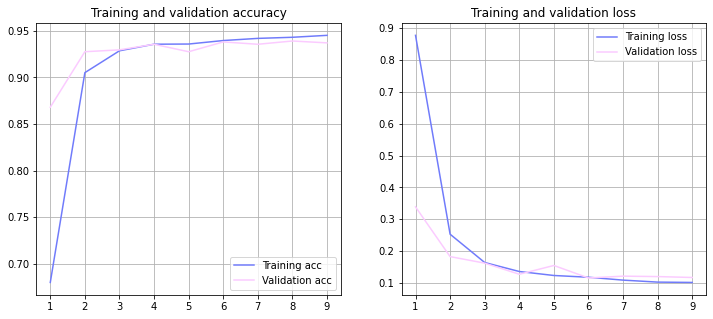

In [38]:
plot_history(history)

In [39]:
model.evaluate(X_test_pad, y_test) 

63/63 [==============================] - 39s 583ms/step - loss: 0.1488 - accuracy: 0.9275


[0.14878688752651215, 0.9275000095367432]

In [40]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

In [41]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       275
           1       0.89      0.74      0.81       159
           2       0.89      0.91      0.90       224
           3       0.92      0.97      0.94       695
           4       0.96      0.97      0.96       581
           5       0.76      0.73      0.74        66

    accuracy                           0.93      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [42]:
# setting a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['#ffffff', '#fbcbff', '#707bfb']
cmap = LinearSegmentedColormap.from_list('mycmap', colors)

In [43]:
def plot_confusion_matrix(matrix, fmt=''):
  '''
  Accepts a confusion matrix and a format param
  Plots the matrix as a heatmap
  Returns nothing

  '''
  plt.figure(figsize=(6, 5))
  sns.heatmap(matrix, annot=True, 
              cmap=cmap, 
              fmt=fmt, 
              xticklabels=emotions_to_labels.keys(), 
              yticklabels=emotions_to_labels.keys())
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

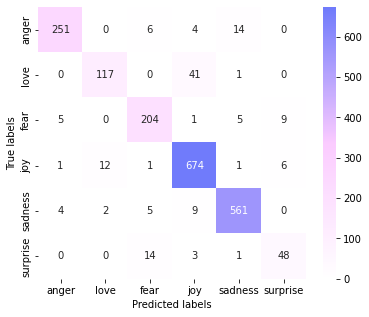

In [44]:
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix)

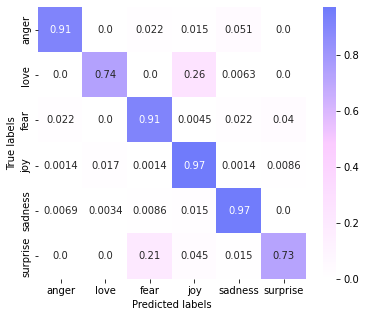

In [45]:
# create new confusion matrix
# where values are normed by row
matrix_new = np.zeros(matrix.shape)

for row in range(len(matrix)):
  sum = np.sum(matrix[row])
  for element in range(len(matrix[row])):
    matrix_new[row][element] = matrix[row][element] / sum

plot_confusion_matrix(matrix_new, fmt='.2')

Test model on custom data

In [46]:
def predict(texts):
  '''
  Accepts array if texts (strings)
  Prints sentence and the corresponding label (emotion)
  Returns nothing
  
  '''
  texts_prepr = [text_preprocess(t) for t in texts]
  sequences = tokenizer.texts_to_sequences(texts_prepr)
  pad = pad_sequences(sequences, maxlen=MAX_LEN)

  predictions = model.predict(pad)
  labels = np.argmax(predictions, axis=1)
  
  for i, lbl in enumerate(labels):
    print(f'\'{texts[i]}\' --> {labels_to_emotions[lbl]}')

In [47]:
test_texts = ['I am so happy', 'The man felt lonely', 'The guests felt satisfied']

predict(test_texts)

'I am so happy' --> joy
'The man felt lonely' --> sadness
'The guests felt satisfied' --> joy
